<a href="https://colab.research.google.com/github/kaylaque/glauco-scan/blob/main/%5BKeras_2_4_0_PreTrained%5DU_Net%2C_OD_cup_on_RIM_ONE_v3%2C_cropped_by_OD_(fold_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip install tensorflow==2.3.0
!pip install keras==2.4
!pip install git+https://github.com/qubvel/segmentation_models
!pip install mahotas

Found existing installation: Keras 2.4.0
Uninstalling Keras-2.4.0:
  Successfully uninstalled Keras-2.4.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: tensorflow 2.3.0
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
  Using cached tensorflow-2.3.0-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached Keras-2.4.0-py2.py3-none-any.whl (170 kB)
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ytgogtch
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ytgogtch
  Running command git submodule update --init --recursive -q
  Using cached mahotas-1.4.11-cp37-cp37m-manylinux2010_x86_64.whl (5.7 MB)


In [ ]:
%cd /content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/scripts

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/scripts


Restart your runtime after do pip install above


### Training of modified U-Net for Optic Disc on RIM-ONE v3 database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/01.03,10:33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from skimage.transform import resize
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import h5py
from tqdm import tqdm_notebook
import mahotas as mh
from IPython.display import display
from dual_IDG import DualImageDataGenerator

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
K.set_image_data_format('channels_first')

In [ ]:
def mean_IOU_cpu_for_binary(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    intersection, union = np.logical_and(X, Y).sum(axis=(1, 2, 3)), np.logical_or(X, Y).sum(axis=(1, 2, 3))
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = np.where(union == 0, 1, union)
    return np.mean(intersection / union.astype(np.float64))


def mean_IOU_cpu(X, Y):
    X_fl = X > 0.5
    Y_fl = Y > 0.5
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))

In [ ]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.greater(X_fl, 0.5)
    Y_fl = K.greater(Y_fl, 0.5)
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_for_flattened(x, y):
    x = K.clip(x, K.epsilon(), 1.)
    y = K.clip(y, K.epsilon(), 1.)
    x = K.greater(x, 0.5)
    y = K.greater(y, 0.5)
    
    intersection = K.sum(x * y, axis=1)
    union = K.sum(K.maximum(x, y), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [ ]:
def bce_gpu(y_true, y_pred):
    # Credits: https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/22951/would-like-to-see-how-others-approached-this-problem-doesn-t-have-to-be/131719
    
    # Workaround for shape bug.
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    
    bce = K.mean(K.binary_crossentropy(y_true_f, y_pred_f), axis=-1)
    return K.mean(bce)

In [ ]:
def dice(y_true, y_pred):
    """This provides a continious approximation to Dice scor.
    It equals Dice score when both y_true and y_pred are binary tensors, 
    however, it also supports tensors with values in [0, 1].
    Therefore, -dice() and -log_dice() can be used for training."""
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def f_score(y_true, y_pred):
    # This function returns f-score (harmonic mean between precision and recall).
    # It is based on Keras function, but first casts inputs to float type.
    
    return fmeasure(K.cast(y_true, 'float32'), K.cast(y_pred, 'float32'))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.greater(y_true, 0.5)
    y_pred_f = K.greater(y_pred, 0.5)
    return dice(y_true_f, y_pred_f)

In [ ]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [ ]:
#h5f = h5py.File("../data/hdf5_datasets/all_data.hdf5", "r")
# h5f = h5py.File("../data/hdf5_datasets/RIM_ONE_v3.hdf5", "r")
h5f = h5py.File("/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/Glaucoma paper - datasets/RIM_ONE_v3.hdf5", "r")

### U-Net architecture


#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [ ]:
# Loading full images of desired resolution:
X = h5f['RIM-ONE v3/512 px/images']
Y = h5f['RIM-ONE v3/512 px/cup']
disc_locations = h5f['RIM-ONE v3/512 px/disc_locations']

In [ ]:
X, Y

(<HDF5 dataset "images": shape (159, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (159, 512, 512, 1), type "|u1">)

In [ ]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5, random_state=1).split(X):
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [ ]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [ ]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.8, 1.2),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

channels_first
channels_first


#### Preprocessing function and data generator:

In [ ]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]
        batch_X = [resize(img, (resize_to, resize_to)) for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

In [ ]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    # the following line thresholds segmentation mask for DRISHTI-GS, since it contains averaged soft maps:
    batch_y = batch_y >= 0.5
    
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i])
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    """Gets random batch of data, 
    divides by 255,
    feeds it to DualImageDataGenerator."""
    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]
        batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
                   for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [ ]:
gen = data_generator(X, Y, 128, 'train', batch_size=1)
batch = gen.__next__()
batch[0].shape

(1, 3, 128, 128)

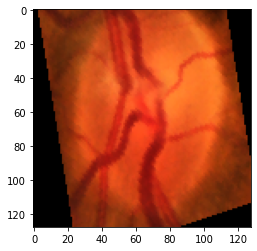

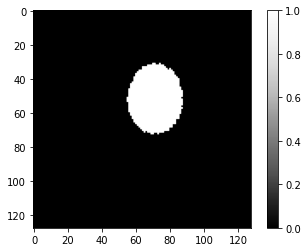

In [ ]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [ ]:
arch_name = "OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = '../models_weights/' \
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name)

In [ ]:
weights_folder

'../models_weights/29.07,13:07,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/'

In [ ]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

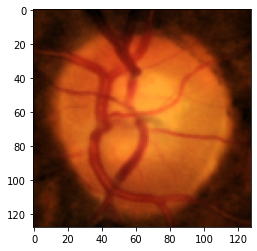

(32, 3, 128, 128) (32, 1, 128, 128)


In [ ]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).__next__()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### [API Segmentation](https://github.com/qubvel/segmentation_models)

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:

#Resnet34 freeze pre trained model
arch_name = "OD Cup, U-Net Resnet34 freeze RIM-ONE fold 0, SGD, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'resnet34'
# preprocess_input = sm.get_preprocessing(BACKBONE)
# gen = data_generator(X, Y, 128, 'train', batch_size=1)
# x_train, y_train = next(gen)

# # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(X_valid)

# define model
model_freeze = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_freeze.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]   
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hitory_f = model_freeze.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=100,
   steps_per_epoch=1000,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,13:07,OD Cup, U-Net Resnet34 freeze RIM-ONE fold 0, SGD, Dice Loss


KeyboardInterrupt: ignored

In [ ]:
def evaluate_model_(history):
    names = [['iou_score', 'val_iou_score'], 
             ['loss', 'val_loss'], 
             ['f1-score', 'val_f1-score']]
            #  ['recall', 'val_recall'], ['precision', 'val_precision']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        

In [ ]:
#Efficientnetb7 freeze pre trained model
arch_name = "OD Cup, U-Net efficientnetb7 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'efficientnetb7'
# preprocess_input = sm.get_preprocessing(BACKBONE)
# gen = data_generator(X, Y, 128, 'train', batch_size=1)
# x_train, y_train = next(gen)

# # # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(X_valid)

# define model
model_eff = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_eff.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model_eff.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=500,
   steps_per_epoch=99,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,16:13,OD Cup, U-Net efficientnetb7 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss
258441216/258434480 [==============================] - 12s 0us/step
Epoch 1/500
99/99 [==============================] - 35s 354ms/step - loss: 0.8055 - iou_score: 0.1110 - f1-score: 0.1945 - val_loss: 0.8454 - val_iou_score: 0.0838 - val_f1-score: 0.1546
Epoch 2/500
99/99 [==============================] - 33s 331ms/step - loss: 0.7923 - iou_score: 0.1199 - f1-score: 0.2077 - val_loss: 0.8346 - val_iou_score: 0.0902 - val_f1-score: 0.1654
Epoch 3/500
99/99 [==============================] - 33s 329ms/step - loss: 0.7658 - iou_score: 0.1388 - f1-score: 0.2342 - val_loss: 0.8047 - val_iou_score: 0.1083 - val_f1-score: 0.1953
Epoch 4/500
99/99 [==============================] - 33s 329ms/step - loss: 0.7545 - iou_score: 0.1464 - f1-score: 0.2455 - val_loss: 0.77

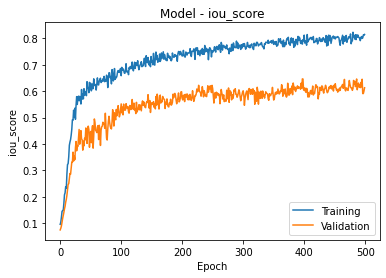

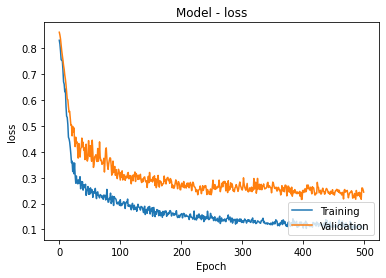

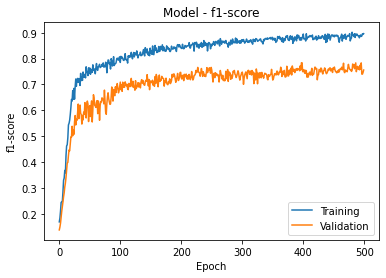

In [ ]:
evaluate_model_(history)

In [ ]:
from tensorflow.keras.applications import MobileNetV2

#MobileNetV2 freeze pre trained model
arch_name = "OD Cup, U-Net mobilenetv2_100 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'mobilenetv2'
# preprocess_input = sm.get_preprocessing(BACKBONE)
# gen = data_generator(X, Y, 128, 'train', batch_size=1)
# x_train, y_train = next(gen)

# # # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(X_valid)

# define model
model_eff = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_eff.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model_eff.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=500,
   steps_per_epoch=99,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,13:08,OD Cup, U-Net mobilenetv2_100 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss


/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/500
99/99 [==============================] - 12s 125ms/step - loss: 0.8164 - iou_score: 0.1050 - f1-score: 0.1836 - val_loss: 0.8559 - val_iou_score: 0.0777 - val_f1-score: 0.1441
Epoch 2/500
99/99 [==============================] - 10s 102ms/step - loss: 0.8022 - iou_score: 0.1143 - f1-score: 0.1978 - val_loss: 0.8479 - val_iou_score: 0.0823 - val_f1-score: 0.1521
Epoch 3/500
99/99 [==============================] - 10s 102ms/step - loss: 0.7950 - iou_score: 0.1188 - f1-score: 0.2050 - val_loss: 0.8433 - val_iou_score: 0.0851 - val_f1-score: 0.1567
Epoch 4/500
99/99 [==============================] - 11s 112ms/step - loss: 0.7920 - iou_score: 0.1218 - f1-score: 0.2080 - val_loss: 0.8389 - val_iou_score: 0.0877 - val_f1-score: 0.1611
Epoch 5/500
99/99 [==============================] - 11s 112ms/step - loss: 0.7819 - iou_score: 0.1273 - f1-score: 0.2181 - val_loss: 0.8341 - val_iou_score: 0.0905 - val_f1-score: 0.16

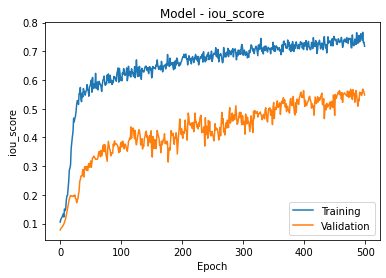

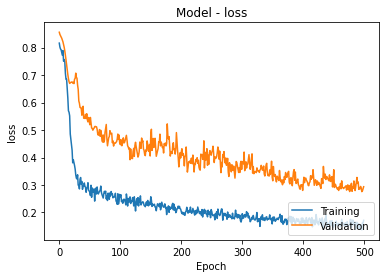

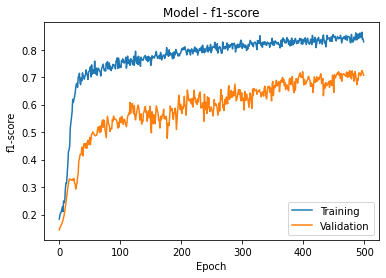

In [ ]:
evaluate_model_(history)

In [ ]:
#ResNet50 freeze pre trained model
arch_name = "OD Cup, U-Net ResNet50 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'resnet50'
# preprocess_input = sm.get_preprocessing(BACKBONE)
# gen = data_generator(X, Y, 128, 'train', batch_size=1)
# x_train, y_train = next(gen)

# # # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(X_valid)

# define model
model_eff = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_eff.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model_eff.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=500,
   steps_per_epoch=99,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,14:34,OD Cup, U-Net ResNet50 freeze RIM ONE 512 px cropped to OD 128 px fold 0, SDG, Dice Loss
94593024/94592056 [==============================] - 5s 0us/step
Epoch 1/500
99/99 [==============================] - 13s 132ms/step - loss: 0.8352 - iou_score: 0.0917 - f1-score: 0.1648 - val_loss: 0.8668 - val_iou_score: 0.0714 - val_f1-score: 0.1332
Epoch 2/500
99/99 [==============================] - 10s 102ms/step - loss: 0.7918 - iou_score: 0.1189 - f1-score: 0.2082 - val_loss: 0.8817 - val_iou_score: 0.0629 - val_f1-score: 0.1183
Epoch 3/500
99/99 [==============================] - 12s 123ms/step - loss: 0.6951 - iou_score: 0.1859 - f1-score: 0.3049 - val_loss: 0.8027 - val_iou_score: 0.1095 - val_f1-score: 0.1973
Epoch 4/500
99/99 [==============================] - 10s 100ms/step - loss: 0.6131 - iou_score: 0.2475 - f1-score: 0.3869 - val_loss: 0.8234 - val_

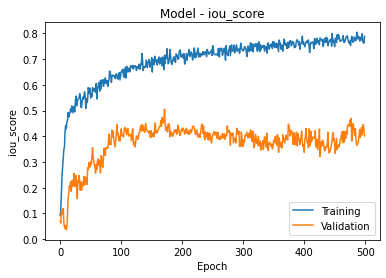

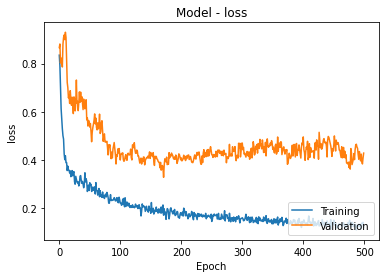

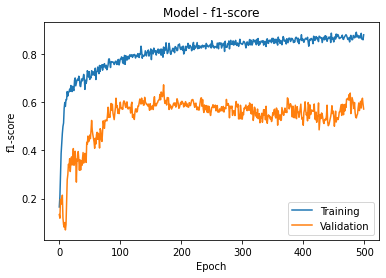

In [ ]:
evaluate_model_(history)

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model_eff.to_json()
with open("model_effnet.json", "w") as json_file:
    json_file.write(model_json)

### Comprehensive visual check

In [ ]:
# Function for rescaling cropped cup region and putting it back into original image,
# and resizing the result to resulting_size.
# Not needed if a model is trained on full (not cropped) images.

def rescale_back(cropped, rectangle, orig_size=(512, 512), resulting_size=(256, 256)):
    # `cropped` must be a grayscale image 
    # rectangle must be an iterable (min_i, min_j, max_i, max_j)
    
    min_i, min_j, max_i, max_j = rectangle
    part_rescaled = sp.misc.imresize(cropped, (max_i - min_i + 1, max_j - min_j + 1))
    resulting_img = np.zeros(orig_size, dtype=cropped.dtype)
    resulting_img[min_i:max_i + 1, min_j:max_j + 1] = part_rescaled
    resulting_img = sp.misc.imresize(resulting_img, resulting_size)
    return resulting_img

image #0


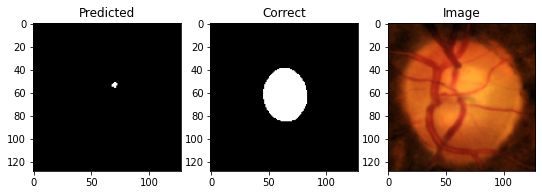

image #1


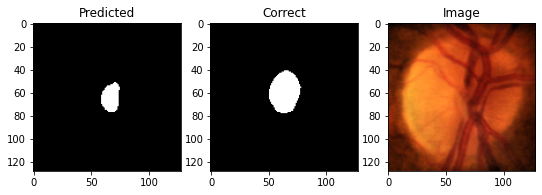

image #2


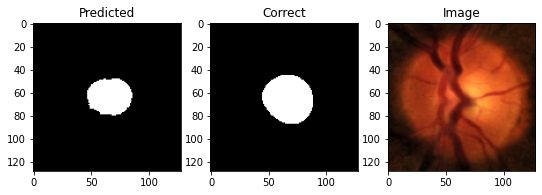

image #3


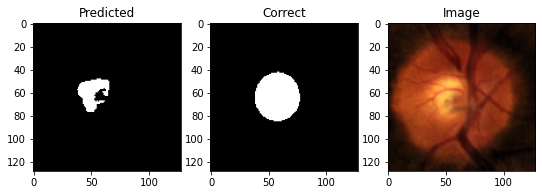

image #4


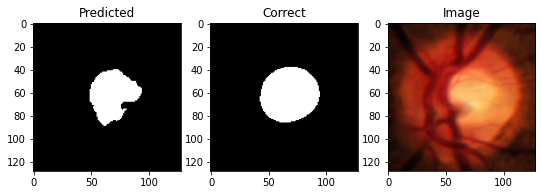

image #5


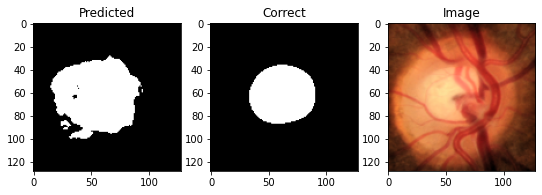

image #6


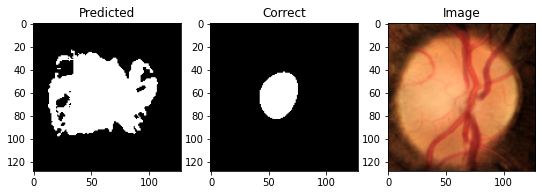

image #7


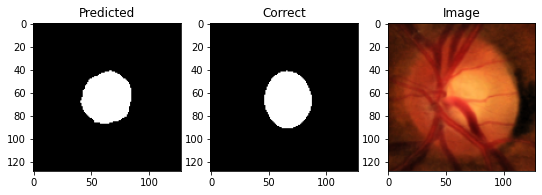

image #8


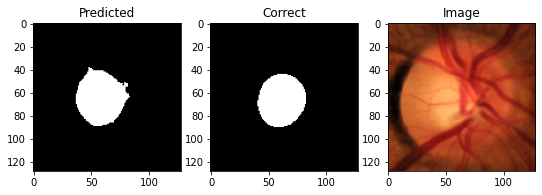

image #9


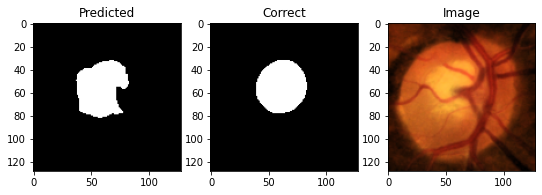

image #10


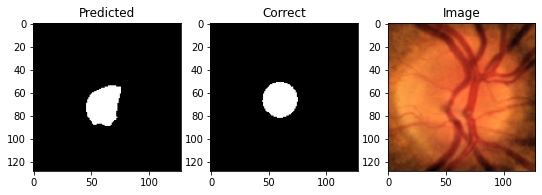

image #11


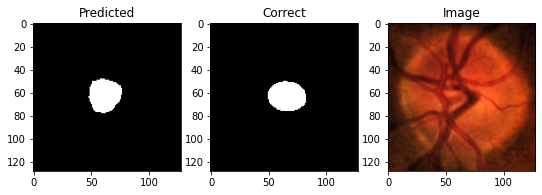

image #12


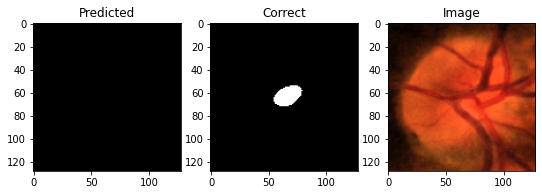

image #13


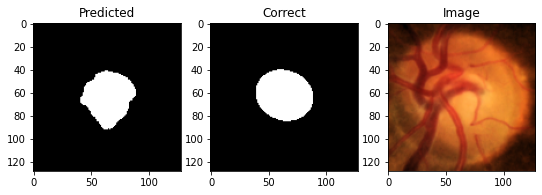

image #14


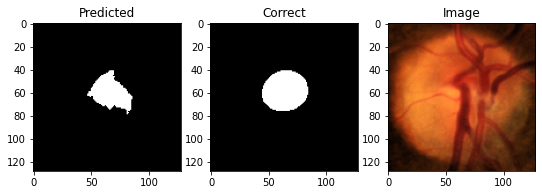

image #15


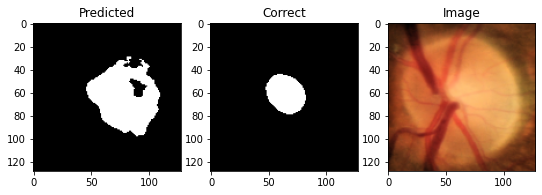

image #16


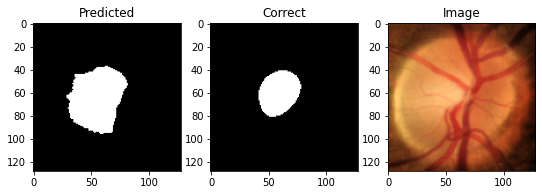

image #17


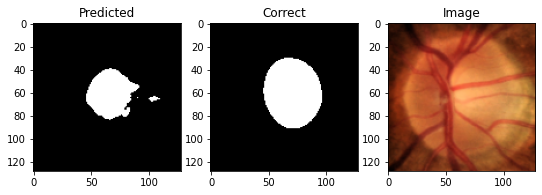

image #18


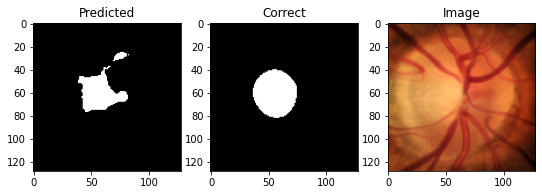

image #19


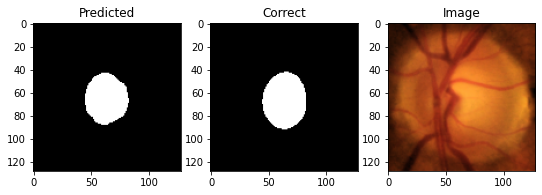

image #20


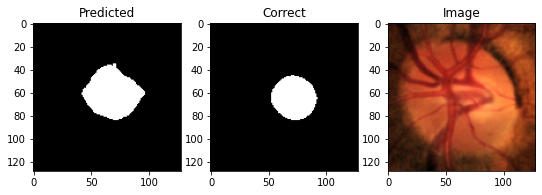

image #21


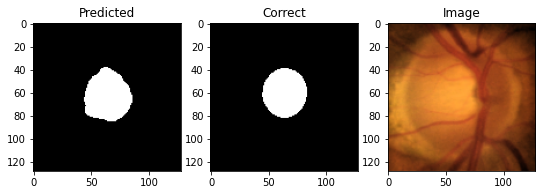

image #22


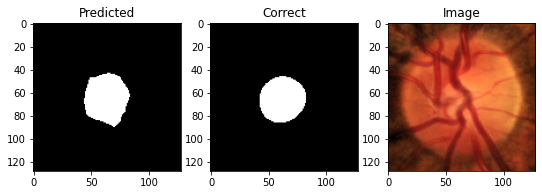

image #23


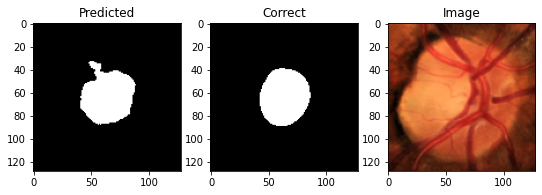

image #24


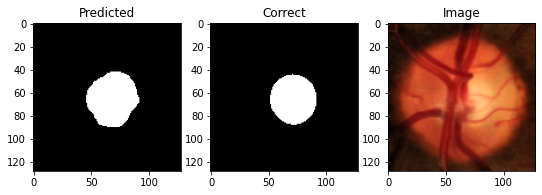

image #25


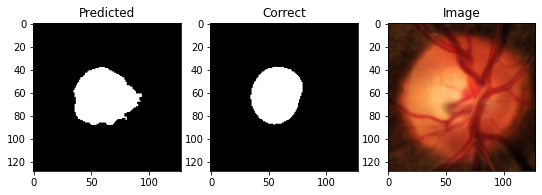

image #26


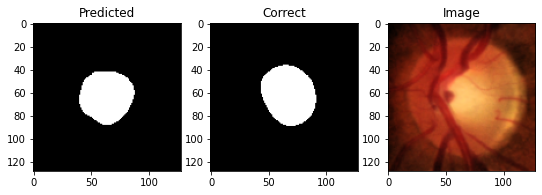

image #27


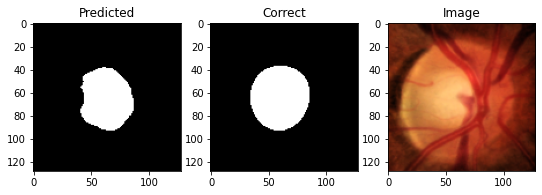

image #28


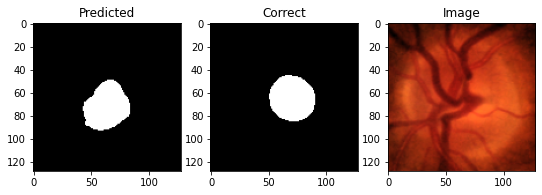

image #29


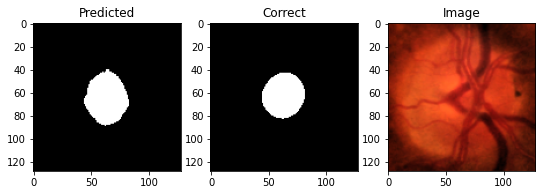

image #30


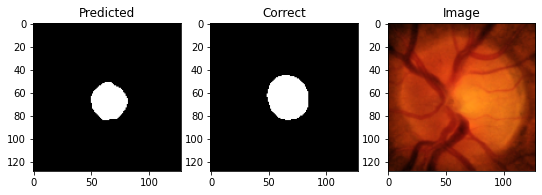

image #31


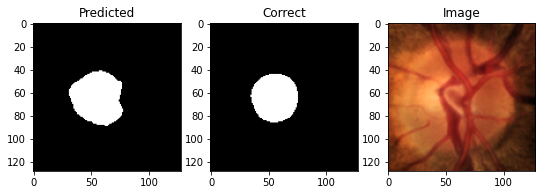

In [ ]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = model_eff.predict(batch_X)[0, 0] > 0.5
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    # for cropped version - comparing with original image:
    #pred = rescale_back(pred, disc_locations[img_no])
    #corr = Y_orig[img_no, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    # cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
    # cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    # print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    # pred_iou.append(cur_iou)
    # pred_dice.append(cur_dice)

### Loading model

In [ ]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    # model_folder = '../models_weights/01.03,10:33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/'
    model_folder = '/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,02:36,OD Cup, U-Net efficientnetb7 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss'
    #model_folder = weights_folder
    
    # model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    model_path = '/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,02:36,OD Cup, U-Net ResNet50 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss/last_checkpoint.hdf5'
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model_eff.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_iou_score'].max()))
        print(log.loc[log['val_iou_score'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_f1-score'].max()))
            print(log.loc[log['val_f1-score'].argmax()])

Loading weights from /content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,02:36,OD Cup, U-Net efficientnetb7 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss/last_checkpoint.hdf5


ValueError: ignored